# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data and package importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [1]:
# Import the packages that we will be using
import pandas as pd
import scipy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
import pydot
import gensim
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input ,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet


# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

2024-05-21 03:29:34.345551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Load the data from a CSV file
rws = pd.read_csv('data.csv')

### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [3]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

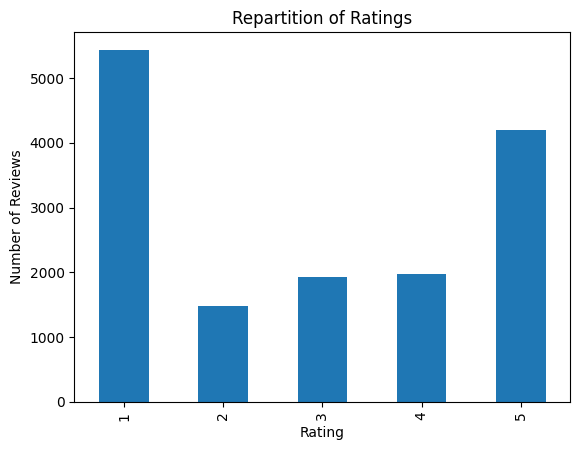

In [4]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


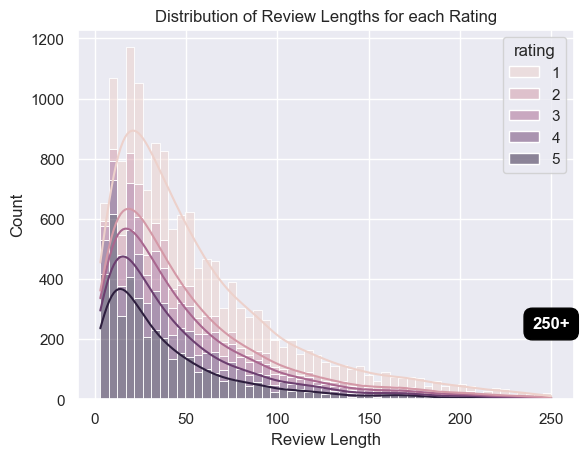

In [5]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [6]:
# Define a function to preprocess the reviews
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']

print(longest_review)

When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [7]:
rws.drop('review_length', axis=1, inplace=True)

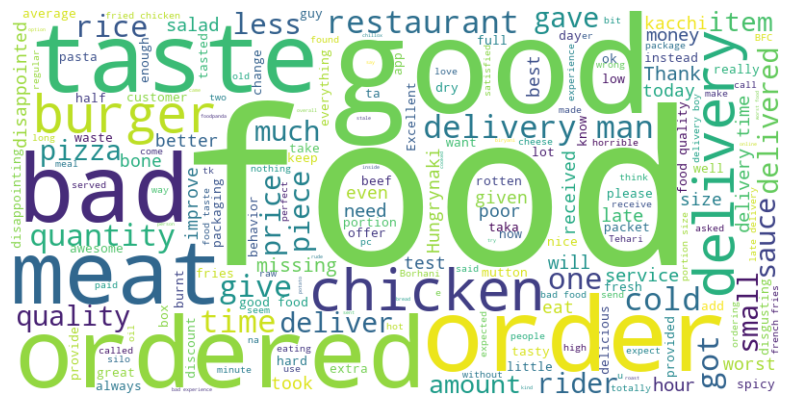

In [8]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [9]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

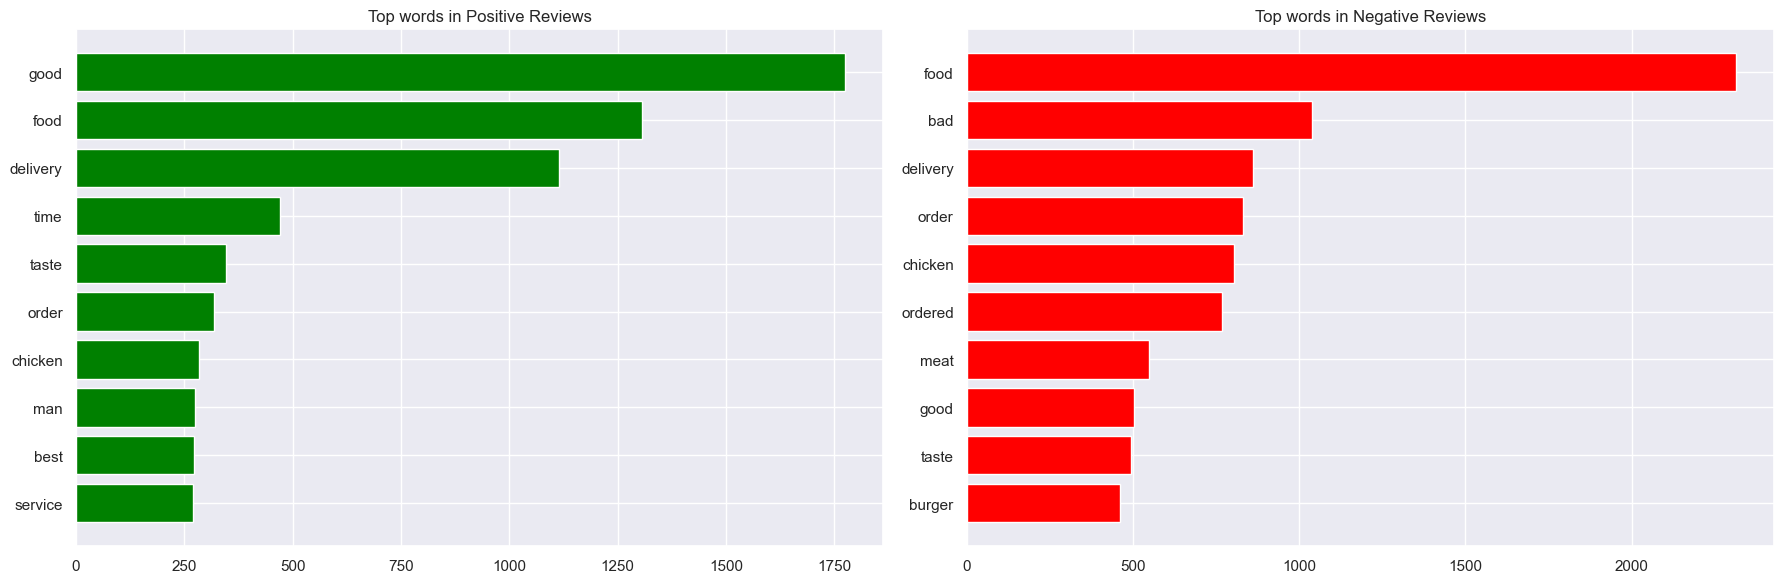

In [10]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


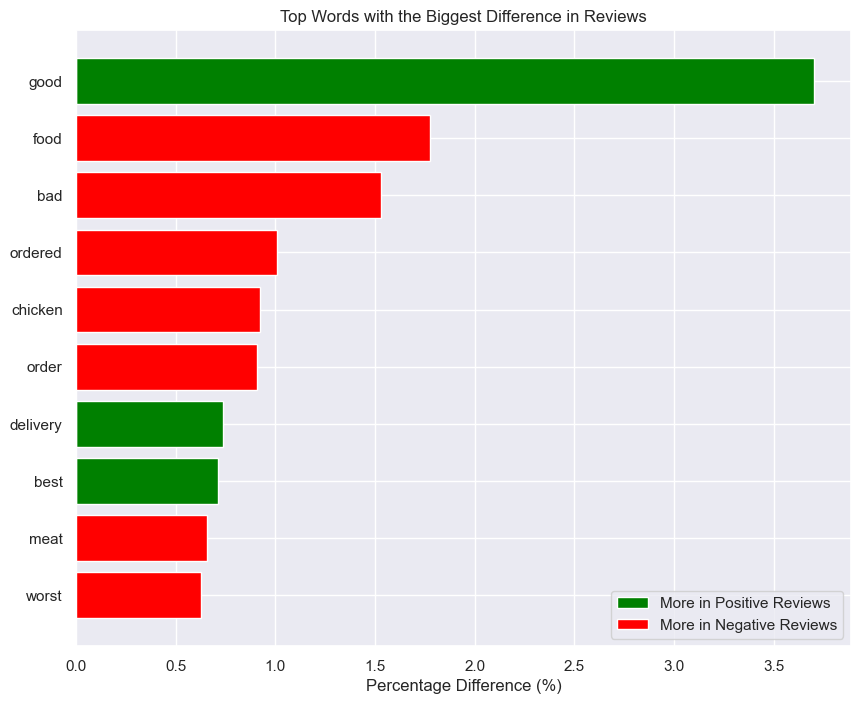

In [11]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [12]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [13]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [14]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [15]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

### Naive Bayes

First, I will be evaluating a Multinomial Naive Bayes model as my baseline

#### Naive Bayes with cleaned data (TF-IDF)

In [16]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0cTI = MultinomialNB()
model_0cTI.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0cTI.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0cTI_accuracy = accuracy_score(cy_test, cy_pred)
m0cTI_precision = precision_score(cy_test, cy_pred, average='weighted')
m0cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m0cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0cTI_accuracy:.2%}", f"{m0cTI_precision:.3f}", f"{m0cTI_recall:.3f}", f"{m0cTI_f1:.3f}", f"{m0cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000000 seconds


#### Naive Bayes with raw data (TF-IDF)

In [17]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0rTI = MultinomialNB()
model_0rTI.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0rTI.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0rTI_accuracy = accuracy_score(ry_test, ry_pred)
m0rTI_precision = precision_score(ry_test, ry_pred, average='weighted')
m0rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m0rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0rTI_accuracy:.2%}", f"{m0rTI_precision:.3f}", f"{m0rTI_recall:.3f}", f"{m0rTI_f1:.3f}", f"{m0rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


#### Storing Results

In [18]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model with TF-IDF
store_results('Model_0cTI', m0cTI_accuracy, m0cTI_precision, m0cTI_recall, m0cTI_f1, m0cTI_time_per_instance)

# Store the results for the raw text model with TF-IDF
store_results('Model_0rTI', m0rTI_accuracy, m0rTI_precision, m0rTI_recall, m0rTI_f1, m0rTI_time_per_instance)

# View the consolidated results
print(results_df)


        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds


### FNN

My initial model is a Feedforward Neural Network (FNN) with 2 different vectorization (TF-IDF and Word2Vec)

#### FNN with cleaned data (TF-IDF)

In [19]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=0)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_tfidf, cy_train, callbacks=[early_stopping])

In [21]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795021 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.729663 (0.008268) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.782173 (0.004716) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.737252 (0.006449) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.762242 (0.004033) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.731484 (0.010707) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.774382 (0.005609) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.736645 (0.004464) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.767806 (0.007398) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.787939 (0.008174) with: {'learning_ra

In [22]:
# Extract the best parameters
best_params = grid_result.best_params_

In [23]:
# Create the final model using the best parameters
model_1cTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ (None, 256)            │     1,714,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,714,433 (6.54 MB)

 Trainable params: 1,714,433 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

None


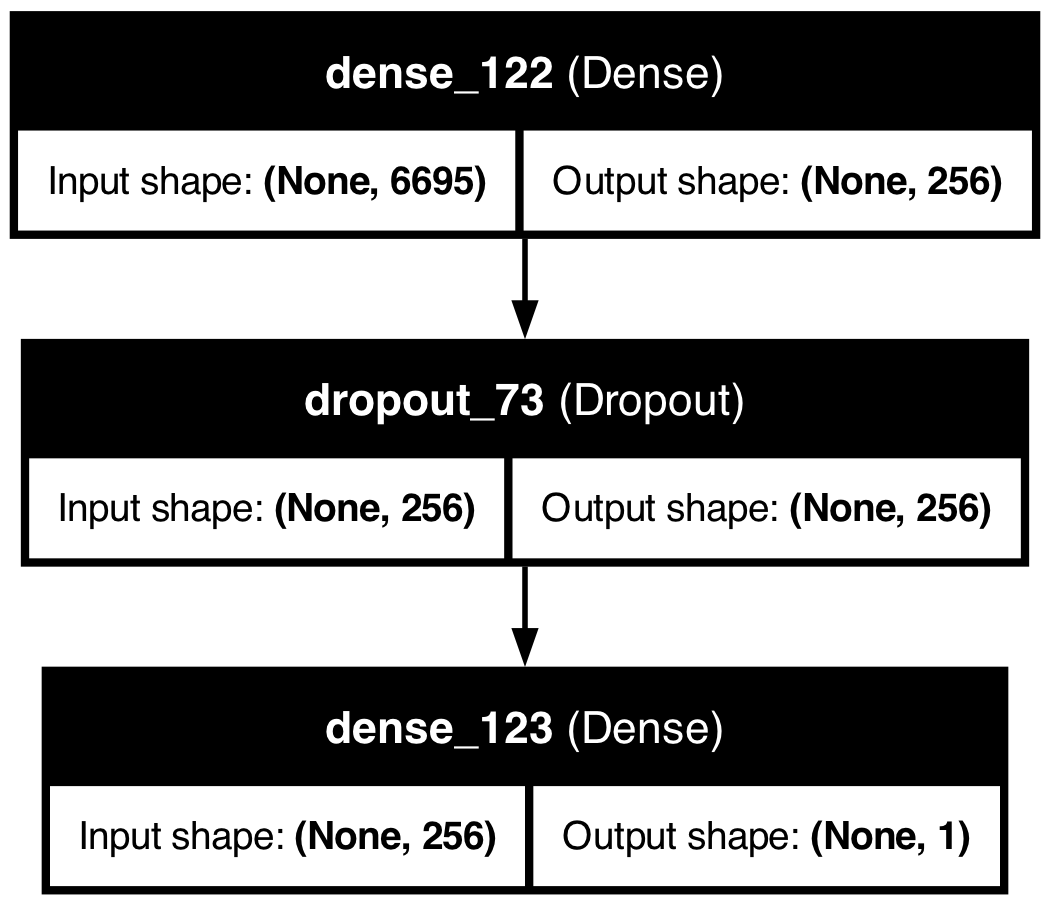

In [24]:
# Generate the plot
plot_model(model_1cTI, show_shapes=True, show_layer_names=True)

In [25]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cTI_history = model_1cTI.fit(
    cX_train_tfidf, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/300


247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6635 - loss: 1.0050
Epoch 1: val_loss improved from inf to 0.72830, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6640 - loss: 1.0041 - val_accuracy: 0.7678 - val_loss: 0.7283 - learning_rate: 1.0000e-04
Epoch 2/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7998 - loss: 0.7016
Epoch 2: val_loss improved from 0.72830 to 0.65556, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7998 - loss: 0.7014 - val_accuracy: 0.7673 - val_loss: 0.6556 - learning_rate: 1.0000e-04
Epoch 3/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8086 - loss: 0.6376
Epoch 3: val_loss improved from 0.65556 to 0.61718, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8086 - loss: 0.6376 - val_accuracy: 0.7719 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc

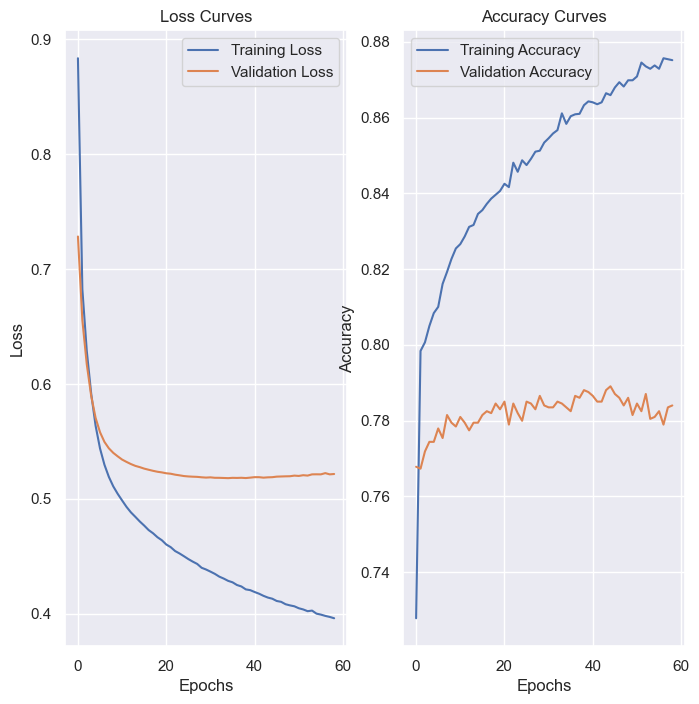

In [141]:
# Create a function to vizuualize the training and validation loss and accuracy
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
    history: TensorFlow History object.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    
# Use the function with your model's history
plot_loss_curves(model_1cTI_history)

In [27]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cTI.predict(cX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cTI_accuracy = accuracy_score(cy_test, cy_pred)
m1cTI_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cTI_accuracy:.2%}", f"{m1cTI_precision:.3f}", f"{m1cTI_recall:.3f}", f"{m1cTI_f1:.3f}", f"{m1cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           78.20%
        precision            0.785
           recall            0.782
         f1_score            0.781
    time/instance 0.000397 seconds


In [28]:
store_results('Model_1cTI', m1cTI_accuracy, m1cTI_precision, m1cTI_recall, m1cTI_f1, m1cTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds


#### FNN with raw data (TF-IDF)

In [29]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=0)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_tfidf, ry_train, callbacks=[early_stopping])

In [31]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795224 using {'learning_rate': 0.0001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.737554 (0.010081) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.779542 (0.002795) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.743322 (0.007469) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.773573 (0.003598) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.735025 (0.010938) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.780757 (0.005385) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.745447 (0.005112) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.772764 (0.002352) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.791582 (0.001275) with: {'learning_ra

In [32]:
# Extract the best parameters
best_params = grid_result.best_params_

In [33]:
# Create the final model using the best parameters
model_1rTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)               │ (None, 128)            │       805,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,377 (3.07 MB)

 Trainable params: 805,377 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

None


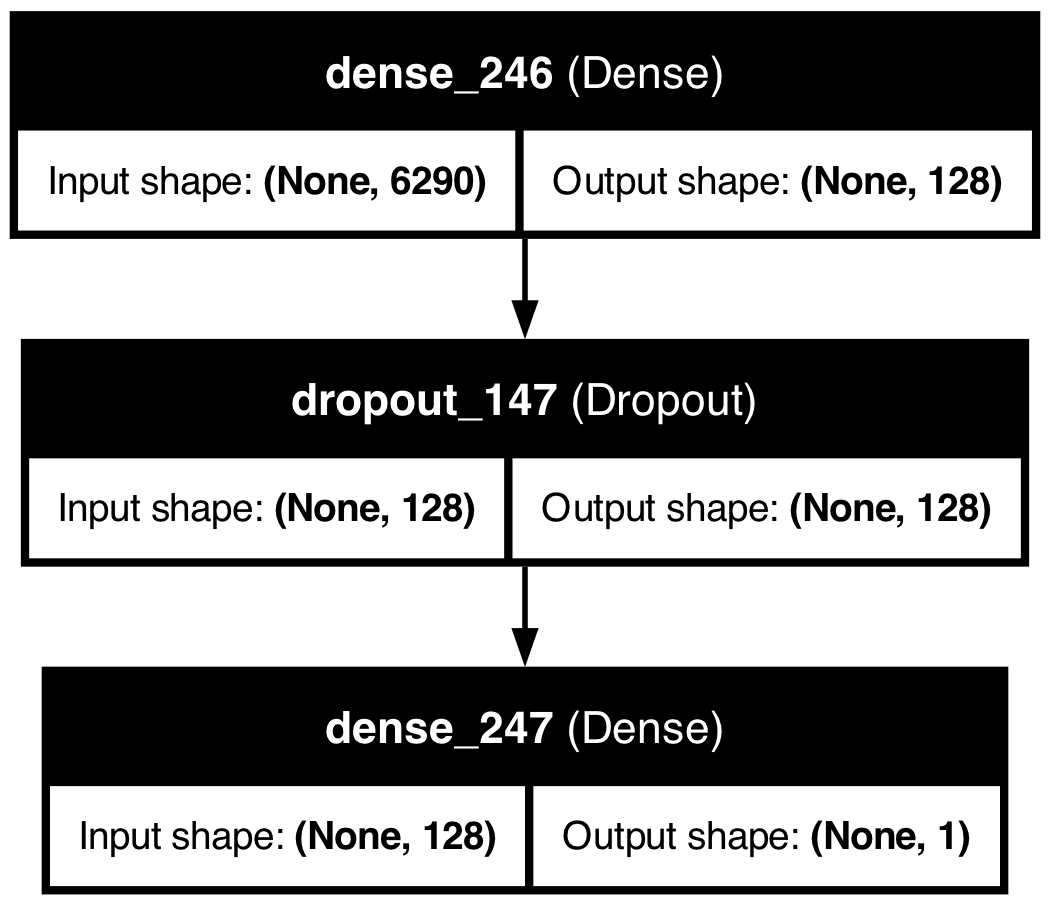

In [34]:
# Generate the plot
plot_model(model_1rTI, show_shapes=True, show_layer_names=True)

Epoch 1/300
240/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5934 - loss: 0.8578
Epoch 1: val_loss improved from inf to 0.71421, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5962 - loss: 0.8555 - val_accuracy: 0.7481 - val_loss: 0.7142 - learning_rate: 1.0000e-04
Epoch 2/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7672 - loss: 0.6987
Epoch 2: val_loss improved from 0.71421 to 0.66905, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7673 - loss: 0.6987 - val_accuracy: 0.7709 - val_loss: 0.6691 - learning_rate: 1.0000e-04
Epoch 3/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7913 - loss: 0.6565
Epoch 3: val_loss improved from 0.66905 to 0.64100, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7913 - loss: 0.6565 - val_accuracy: 0.7699 - val_loss: 0.6410 - learning_rate: 1.0000e-04
Epoch 4/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

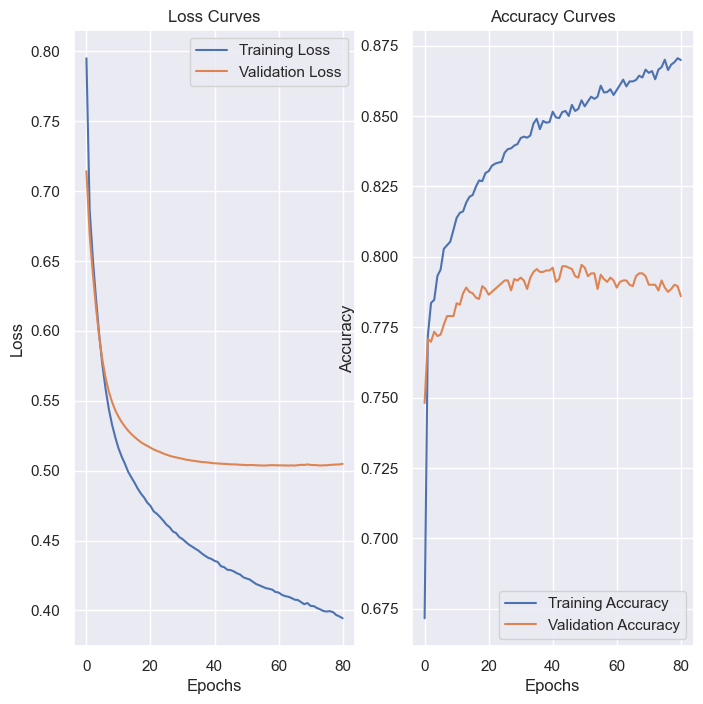

In [35]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rTI_history = model_1rTI.fit(
    rX_train_tfidf, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_1rTI_history)

In [36]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rTI.predict(rX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rTI_accuracy = accuracy_score(ry_test, ry_pred)
m1rTI_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rTI_accuracy:.2%}", f"{m1rTI_precision:.3f}", f"{m1rTI_recall:.3f}", f"{m1rTI_f1:.3f}", f"{m1rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           79.49%
        precision            0.797
           recall            0.795
         f1_score            0.795
    time/instance 0.000296 seconds


In [37]:
store_results('Model_1rTI', m1rTI_accuracy, m1rTI_precision, m1rTI_recall, m1rTI_f1, m1rTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds


#### Word2Vec Vectorization

In [38]:
# Tokenize reviews
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)

In [39]:
# Tokenize reviews
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)

#### FNN with cleaned data (Word2Vec)

In [40]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=0)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_vec, cy_train, callbacks=[early_stopping])

In [42]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.713679 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.711149 (0.006231) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.580636 (0.043861) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.683929 (0.029178) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.500607 (0.001195) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.713679 (0.009823) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.555947 (0.014053) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.712364 (0.008422) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.496763 (0.011991) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.639317 (0.006771) with: {'learning_rate': 

In [43]:
# Extract the best parameters
best_params = grid_result.best_params_

In [44]:
# Create the final model using the best parameters
model_1cWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,513 (252.00 KB)

 Trainable params: 64,513 (252.00 KB)

 Non-trainable params: 0 (0.00 B)

None


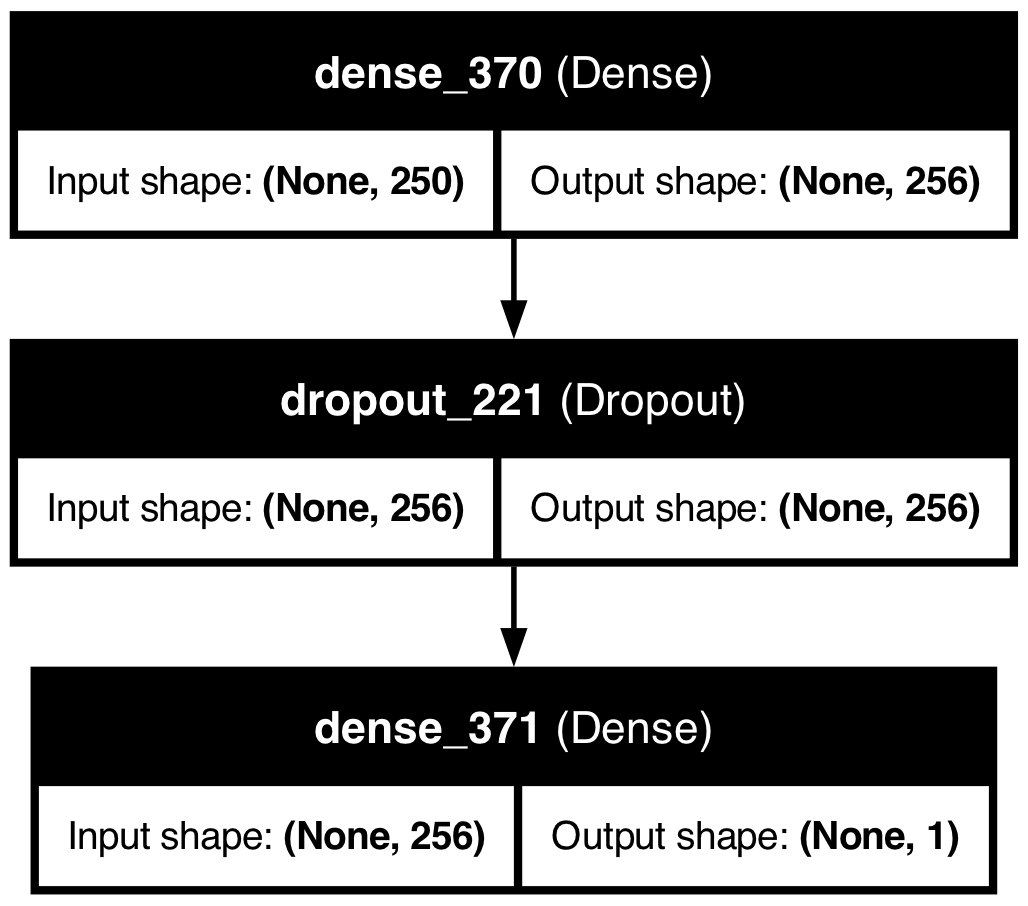

In [45]:
# Generate the plot
plot_model(model_1cWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5118 - loss: 0.6960
Epoch 1: val_loss improved from inf to 0.67955, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5119 - loss: 0.6959 - val_accuracy: 0.6287 - val_loss: 0.6795 - learning_rate: 0.0010
Epoch 2/300
235/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5589 - loss: 0.6847
Epoch 2: val_loss improved from 0.67955 to 0.67210, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5595 - loss: 0.6845 - val_accuracy: 0.5837 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 3/300
243/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5841 - loss: 0.6738
Epoch 3: val_loss improved from 0.67210 to 0.66171, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5842 - loss: 0.6738 - val_accuracy: 0.6464 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 4/300
227/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

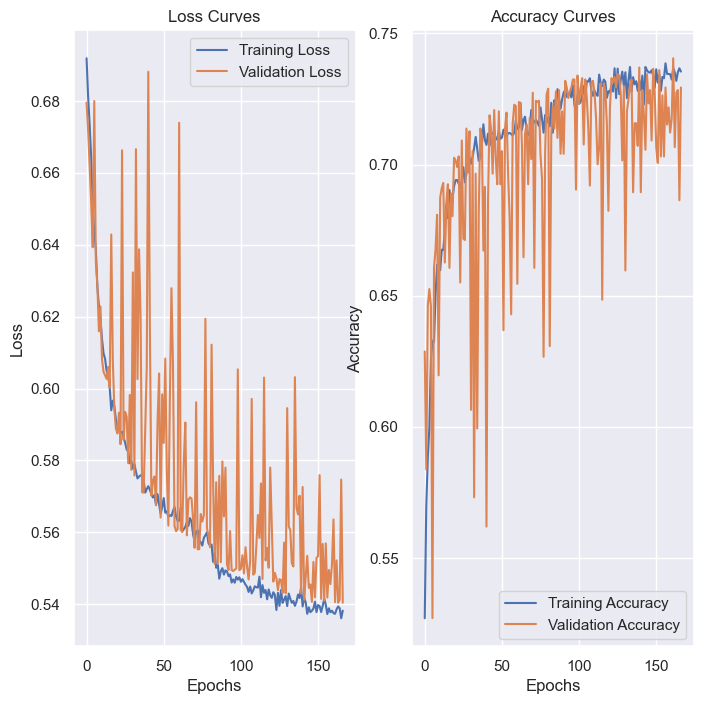

In [46]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cWV_history = model_1cWV.fit(
    cX_train_vec, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1cWV_history)

In [47]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cWV.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cWV_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cWV_accuracy = accuracy_score(cy_test, cy_pred)
m1cWV_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cWV_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cWV_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cWV_accuracy:.2%}", f"{m1cWV_precision:.3f}", f"{m1cWV_recall:.3f}", f"{m1cWV_f1:.3f}", f"{m1cWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           74.07%
        precision            0.743
           recall            0.741
         f1_score            0.740
    time/instance 0.000223 seconds


In [48]:
store_results('Model_1cWV', m1cWV_accuracy, m1cWV_precision, m1cWV_recall, m1cWV_f1, m1cWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds


#### FNN with raw data (Word2Vec)

In [49]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=0)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_vec, ry_train, callbacks=[early_stopping])

In [51]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.708923 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.699008 (0.008754) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.659855 (0.016146) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.703054 (0.011358) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.680292 (0.007363) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.708923 (0.004991) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.654897 (0.009272) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.702146 (0.010040) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.663292 (0.018644) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.659349 (0.001421) with: {'learning_rate': 

In [52]:
# Extract the best parameters
best_params = grid_result.best_params_

In [53]:
# Create the final model using the best parameters
model_1rWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_494 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,513 (252.00 KB)

 Trainable params: 64,513 (252.00 KB)

 Non-trainable params: 0 (0.00 B)

None


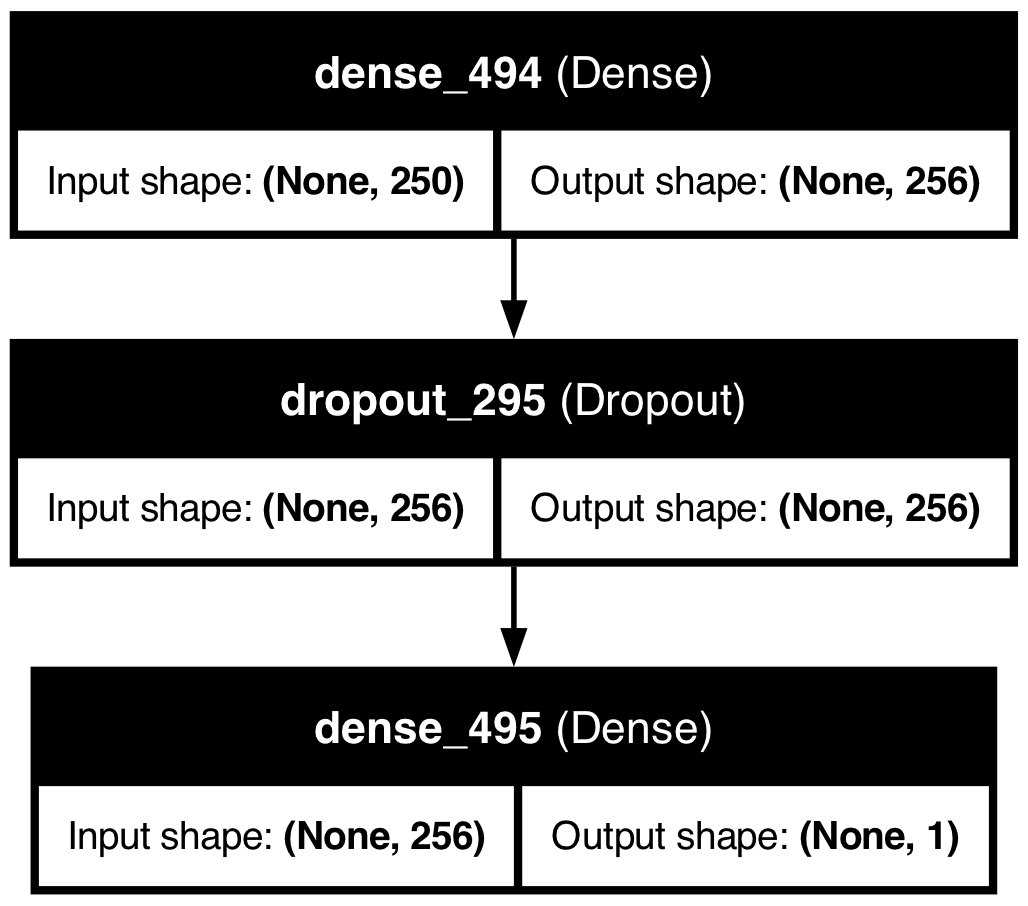

In [54]:
# Generate the plot
plot_model(model_1rWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
238/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5895 - loss: 0.6710
Epoch 1: val_loss improved from inf to 0.64835, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5906 - loss: 0.6704 - val_accuracy: 0.6343 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 2/300
221/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.6399
Epoch 2: val_loss did not improve from 0.64835
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6412 - loss: 0.6402 - val_accuracy: 0.6090 - val_loss: 0.6541 - learning_rate: 0.0010
Epoch 3/300
228/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.6401
Epoch 3: val_loss improved from 0.64835 to 0.62641, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6359 - loss: 0.6395 - val_accuracy: 0.6545 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 4/300
222/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 0.6325
Epoch 4: val_los

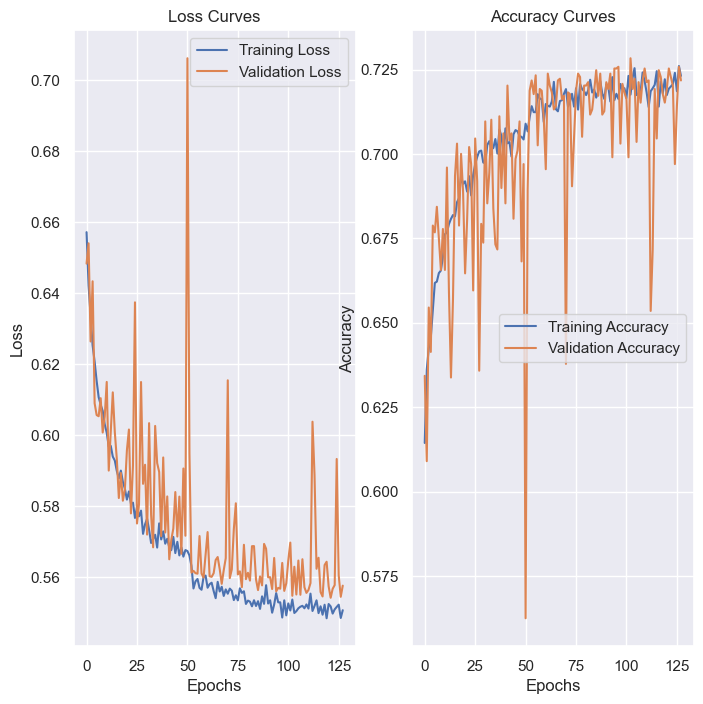

In [55]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rWV_history = model_1rWV.fit(
    rX_train_vec, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1rWV_history)

In [56]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rWV.predict(rX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rWV_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rWV_accuracy = accuracy_score(ry_test, ry_pred)
m1rWV_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rWV_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rWV_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rWV_accuracy:.2%}", f"{m1rWV_precision:.3f}", f"{m1rWV_recall:.3f}", f"{m1rWV_f1:.3f}", f"{m1rWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           72.37%
        precision            0.726
           recall            0.724
         f1_score            0.723
    time/instance 0.000192 seconds


In [57]:
store_results('Model_1rWV', m1rWV_accuracy, m1rWV_precision, m1rWV_recall, m1rWV_f1, m1rWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds


### LSTM (single layer)

My second model is a LSTM with a single layer

#### LSTM reshaping

In [58]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your training data
tokenizer.fit_on_texts(cX_train)
# Convert texts to sequences
cx_train_seq = tokenizer.texts_to_sequences(cX_train)
cx_test_seq = tokenizer.texts_to_sequences(cX_test)
# Get the word index
word_index = tokenizer.word_index
# Vocabulary size
vocab_sizeC = len(word_index) + 1
print("Vocab size:", vocab_sizeC)
# Determine the length of each sequence
sequence_lengths = [len(seq) for seq in cx_train_seq]
# Calculate the 95th percentile of sequence lengths
max_lengthC = int(np.percentile(sequence_lengths, 95))
print("Max length:", max_lengthC)
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(cx_train_seq, maxlen=max_lengthC, padding='post')
padded_sequencesT = pad_sequences(cx_test_seq, maxlen=max_lengthC, padding='post')
# The training data is now padded_sequences
cX_train_pad = padded_sequences
cX_test_pad = padded_sequencesT
# Print padded sequences
print("Padded sequences:", cX_train_pad)
cX_train_lstm = cX_train_pad  # Preprocessed input data for the LSTM model
cX_test_lstm = cX_test_pad  # Preprocessed input data for the LSTM model

Vocab size: 6341
Max length: 20
Padded sequences: [[ 510  181 1620 ...    0    0    0]
 [   4    9    0 ...    0    0    0]
 [1990  179  146 ...    0    0    0]
 ...
 [ 117   60   48 ...    0    0    0]
 [  32    5    2 ...    0    0    0]
 [  53   49    0 ...    0    0    0]]


In [59]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your training data
tokenizer.fit_on_texts(rX_train)
# Convert texts to sequences
rx_train_seq = tokenizer.texts_to_sequences(rX_train)
rx_test_seq = tokenizer.texts_to_sequences(rX_test)
# Get the word index
word_index = tokenizer.word_index
# Vocabulary size
vocab_sizeR = len(word_index) + 1
print("Vocab size:", vocab_sizeR)  
# Determine the length of each sequence
sequence_lengths = [len(seq) for seq in rx_train_seq]
# Calculate the 95th percentile of sequence lengths
max_lengthR = int(np.percentile(sequence_lengths, 95))
print("Max length:", max_lengthR)
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(rx_train_seq, maxlen=max_lengthR, padding='post')
padded_sequencesT = pad_sequences(rx_test_seq, maxlen=max_lengthR, padding='post')
# The training data is now padded_sequences
rX_train_pad = padded_sequences
rX_test_pad = padded_sequencesT
# Print padded sequences
print("Padded sequences:", rX_train_pad)
rX_train_lstm = rX_train_pad  # Preprocessed input data for the LSTM model
rX_test_lstm = rX_test_pad  # Preprocessed input data for the LSTM model


Vocab size: 6340
Max length: 35
Padded sequences: [[ 634  254   70 ...    0    0    0]
 [  12   23    0 ...    0    0    0]
 [2340  635  229 ...    0    0    0]
 ...
 [  25   24    2 ...    0    0    0]
 [  65   13    7 ...    0    0    0]
 [  98   95    0 ...    0    0    0]]


#### LSTM (single layer) with cleaned data

In [ ]:
def create_model(input_length=max_lengthC, input_dim=vocab_sizeC, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthC,
    input_dim=vocab_sizeC,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Define the grid search parameters
param_grid = {
    'lstm_units': [256,512],  # Focused values for LSTM units
    'learning_rate': [0.001,0.0001],  # Narrow range for learning rate
    'output_dim': [128,256]  # Output dimensions of Embedding layer
}

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [61]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.759004 using {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.755260 (0.008475) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.752225 (0.005485) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.750505 (0.005703) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.757081 (0.005604) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.759004 (0.004757) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.752934 (0.004326) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.752124 (0.003178) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.754248 (0.010684) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [62]:
# Extract the best parameters
best_params = grid_result.best_params_

In [63]:
# Create the final model using the best parameters
model_2cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_2cIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_795"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_201 (InputLayer)    │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 20, 128)        │       811,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,145 (4.60 MB)

 Trainable params: 1,206,145 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

None


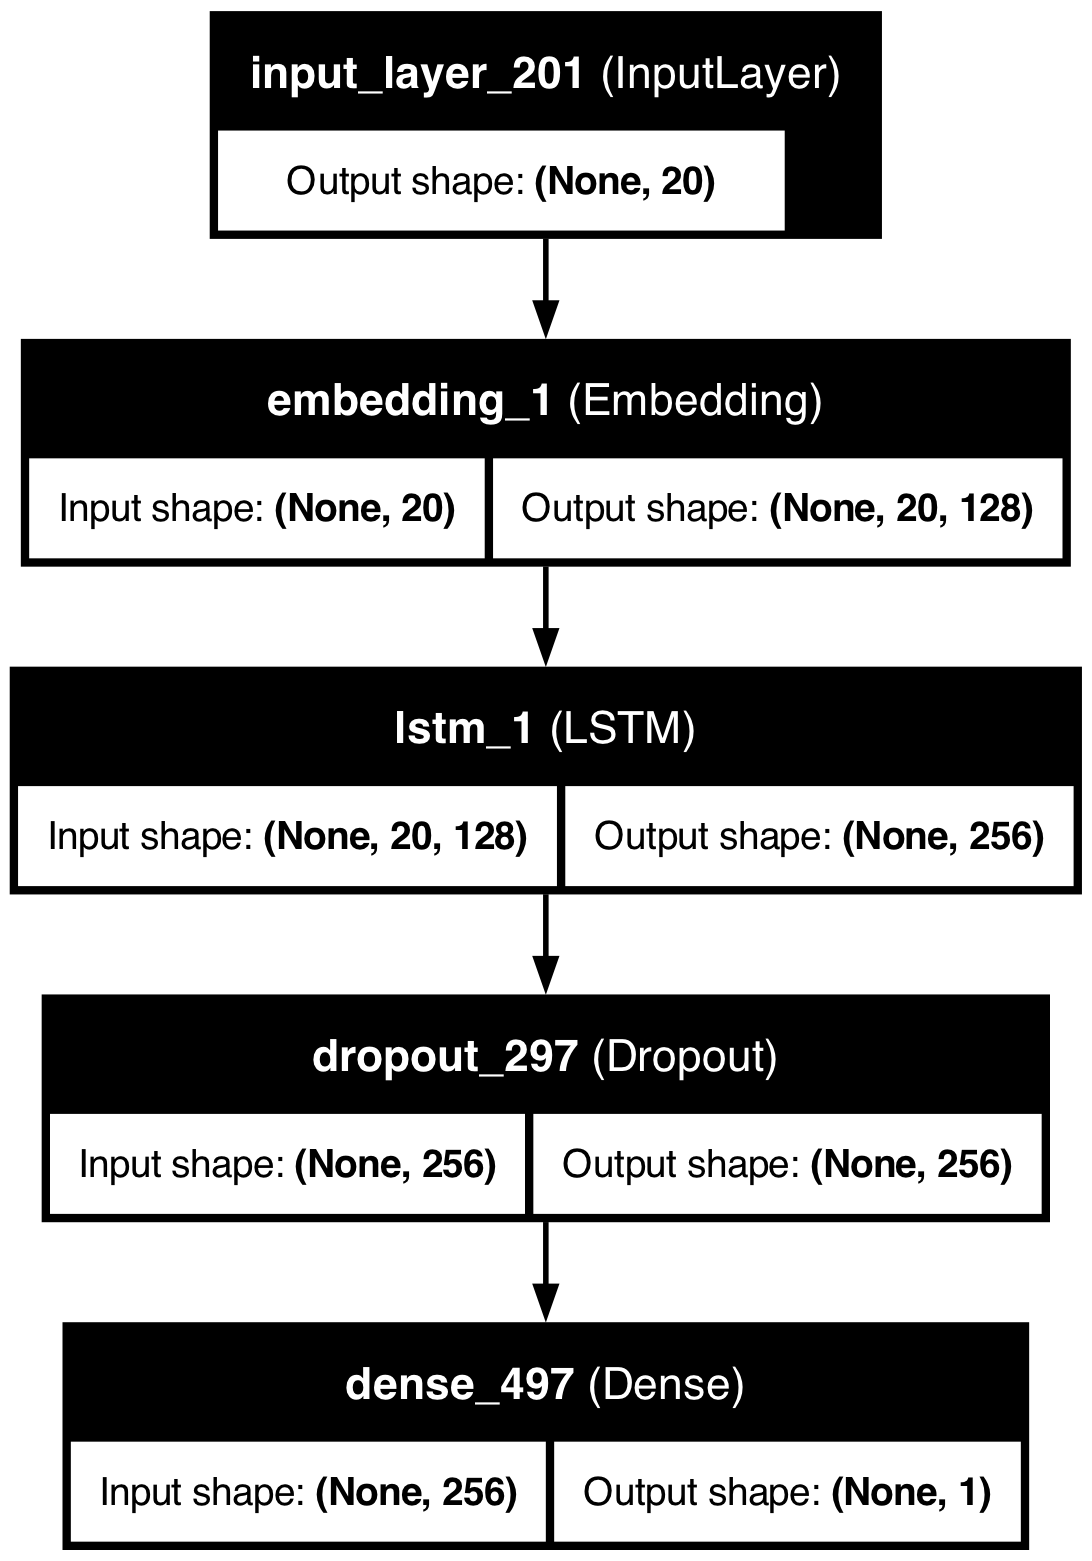

In [64]:
# Generate the plot
plot_model(model_2cIT, show_shapes=True, show_layer_names=True)

In [65]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2cIT_history = model_2cIT.fit(
    cX_train_lstm, cy_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5507 - loss: 1.5822
Epoch 1: val_loss improved from inf to 0.93660, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5511 - loss: 1.5812 - val_accuracy: 0.7613 - val_loss: 0.9366 - learning_rate: 1.0000e-04
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7919 - loss: 0.8139
Epoch 2: val_loss improved from 0.93660 to 0.68859, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7919 - loss: 0.8136 - val_accuracy: 0.7769 - val_loss: 0.6886 - learning_rate: 1.0000e-04
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8316 - loss: 0.5679
Epoch 3: val_loss improved from 0.68859 to 0.59893, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8316 - loss: 0.5678 - val_accuracy: 0.7795 - val_loss: 0.5989 - learning_rate: 1.0000e-04
Epoch 4/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms

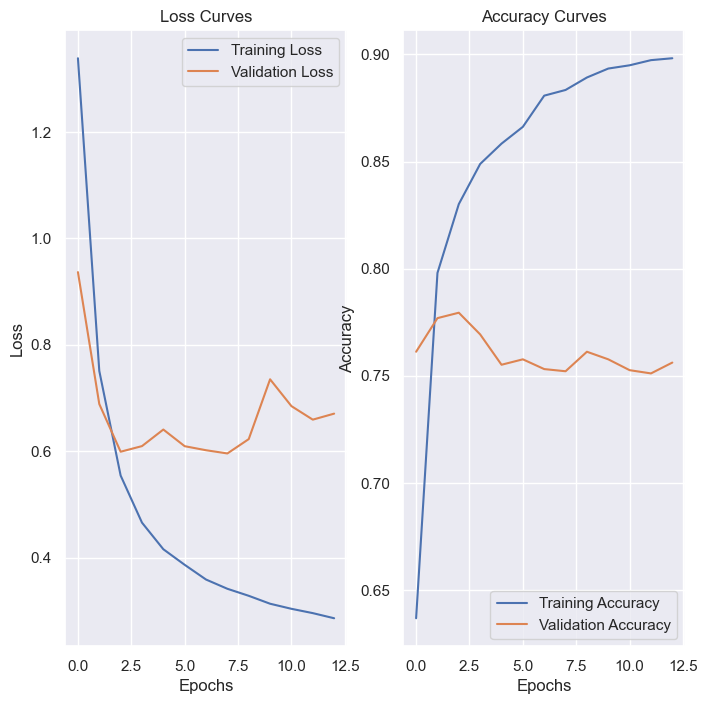

In [66]:
# Use the function with your model's history
plot_loss_curves(model_2cIT_history) 

In [67]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2cIT_time_per_instance = (end_time - start_time) / len(cX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m2cIT_accuracy = accuracy_score(cy_test, cy_pred)
m2cIT_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m2cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2cIT_accuracy:.2%}", f"{m2cIT_precision:.3f}", f"{m2cIT_recall:.3f}", f"{m2cIT_f1:.3f}", f"{m2cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Model Performance          Results
         accuracy           75.93%
        precision            0.760
           recall            0.759
         f1_score            0.759
    time/instance 0.000928 seconds


In [68]:
store_results('Model_2c', m2cIT_accuracy, m2cIT_precision, m2cIT_recall, m2cIT_f1, m2cIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds


#### LSTM (single layer) with raw data

In [69]:
def create_model(input_length=max_lengthR, input_dim=vocab_sizeR, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.005):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthR,
    input_dim=vocab_sizeR,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
#grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [70]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.759004 using {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.755260 (0.008475) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.752225 (0.005485) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.750505 (0.005703) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.757081 (0.005604) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.759004 (0.004757) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.752934 (0.004326) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.752124 (0.003178) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.754248 (0.010684) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [71]:
# Extract the best parameters
best_params = grid_result.best_params_

In [72]:
# Create the final model using the best parameters
model_2rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_2rIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_797"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_202 (InputLayer)    │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 35, 128)        │       811,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,017 (4.60 MB)

 Trainable params: 1,206,017 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

None


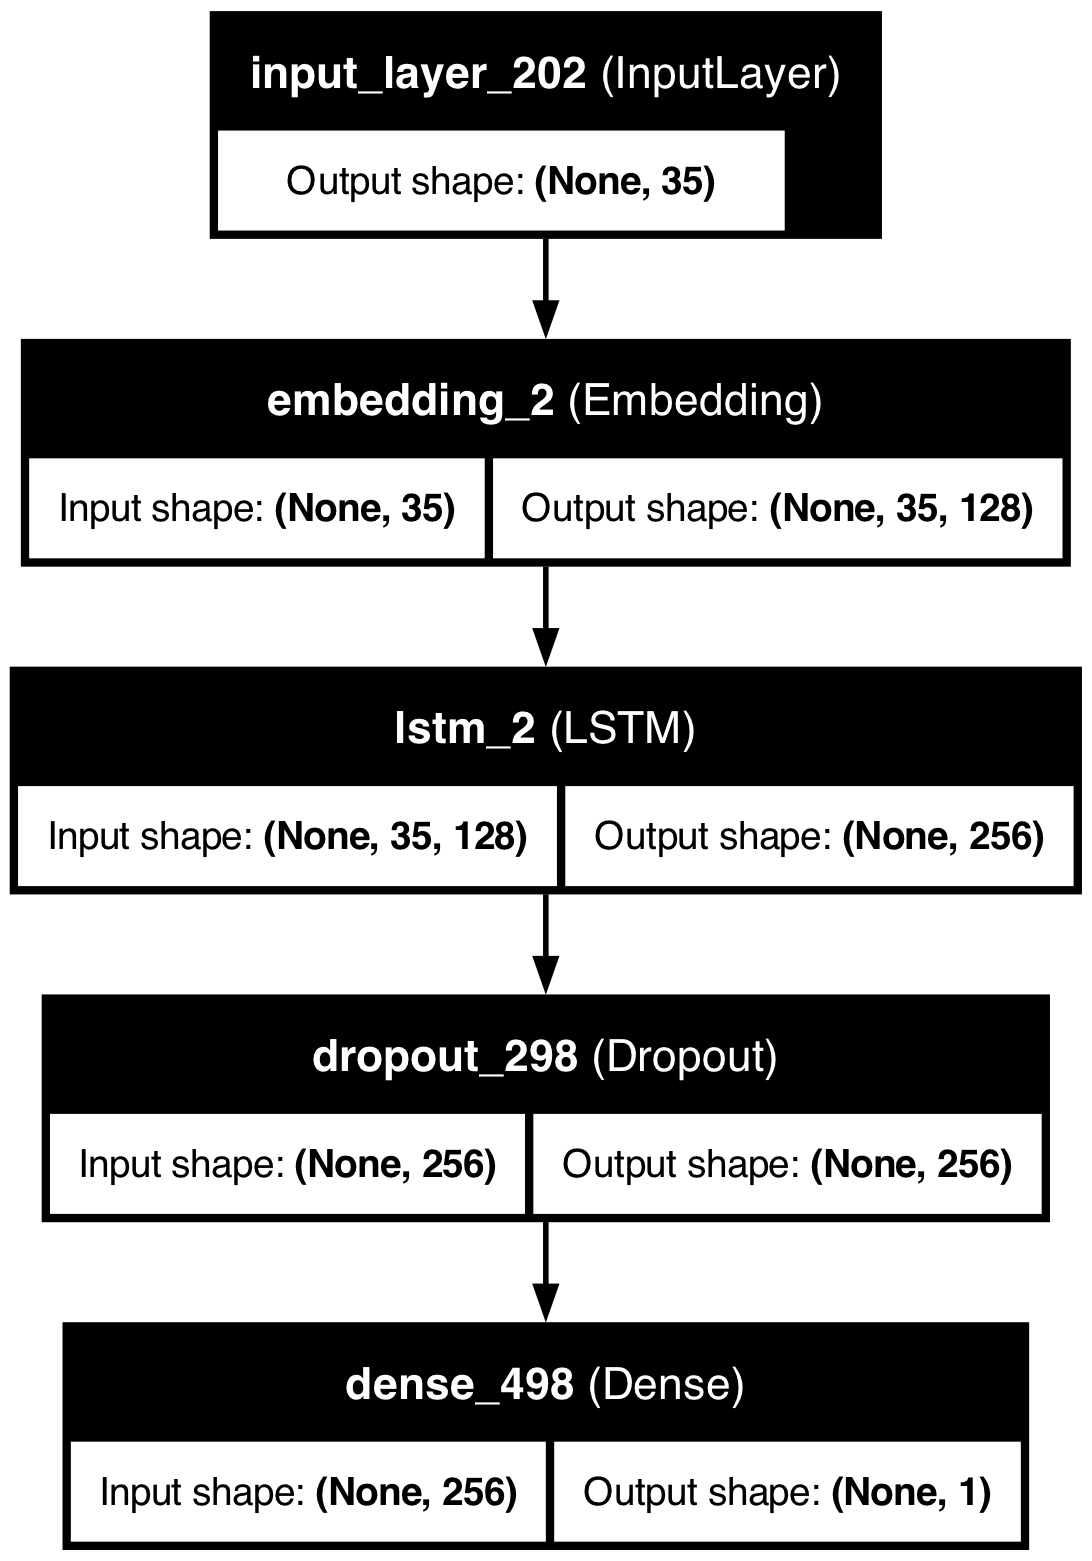

In [73]:
# Generate the plot
plot_model(model_2rIT, show_shapes=True, show_layer_names=True)

Epoch 1/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5286 - loss: 1.6047
Epoch 1: val_loss improved from inf to 0.95567, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5291 - loss: 1.6029 - val_accuracy: 0.7562 - val_loss: 0.9557 - learning_rate: 1.0000e-04
Epoch 2/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7838 - loss: 0.8422
Epoch 2: val_loss improved from 0.95567 to 0.69722, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.7838 - loss: 0.8416 - val_accuracy: 0.7628 - val_loss: 0.6972 - learning_rate: 1.0000e-04
Epoch 3/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8333 - loss: 0.5715
Epoch 3: val_loss improved from 0.69722 to 0.59553, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.8333 - loss: 0.5713 - val_accuracy: 0.7749 - val_loss: 0.5955 - learning_rate: 1.0000e-04
Epoch 4/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms

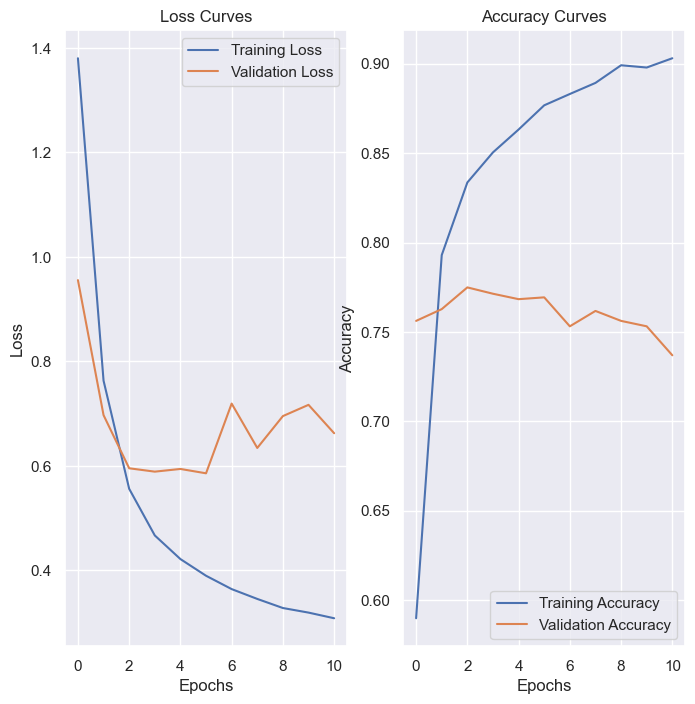

In [74]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2rIT_history = model_2rIT.fit(
    rX_train_lstm, ry_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_2rIT_history)

In [75]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob> 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m2rIT_accuracy = accuracy_score(ry_test, ry_pred)
m2rIT_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m2rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2rIT_accuracy:.2%}", f"{m2rIT_precision:.3f}", f"{m2rIT_recall:.3f}", f"{m2rIT_f1:.3f}", f"{m2rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Model Performance          Results
         accuracy           76.74%
        precision            0.770
           recall            0.767
         f1_score            0.767
    time/instance 0.001405 seconds


In [76]:
store_results('Model_2r', m2rIT_accuracy, m2rIT_precision, m2rIT_recall, m2rIT_f1, m2rIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7    Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds


### LSTM (stacked)

Now I use another LSTM (LSTM stacked)

#### LSTM (stacked) with cleaned data

In [77]:
def create_model(input_length=max_lengthC, input_dim=vocab_sizeC, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthC,
    input_dim=vocab_sizeC,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
#grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [78]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.759004 using {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.755260 (0.008475) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.752225 (0.005485) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.750505 (0.005703) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.757081 (0.005604) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.759004 (0.004757) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.752934 (0.004326) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.752124 (0.003178) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.754248 (0.010684) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [79]:
# Extract the best parameters
best_params = grid_result.best_params_

In [80]:
# Create the final model using the best parameters
model_3cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_3cIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_799"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_203 (InputLayer)    │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 20, 128)        │       811,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_300 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,457 (6.60 MB)

 Trainable params: 1,731,457 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

None


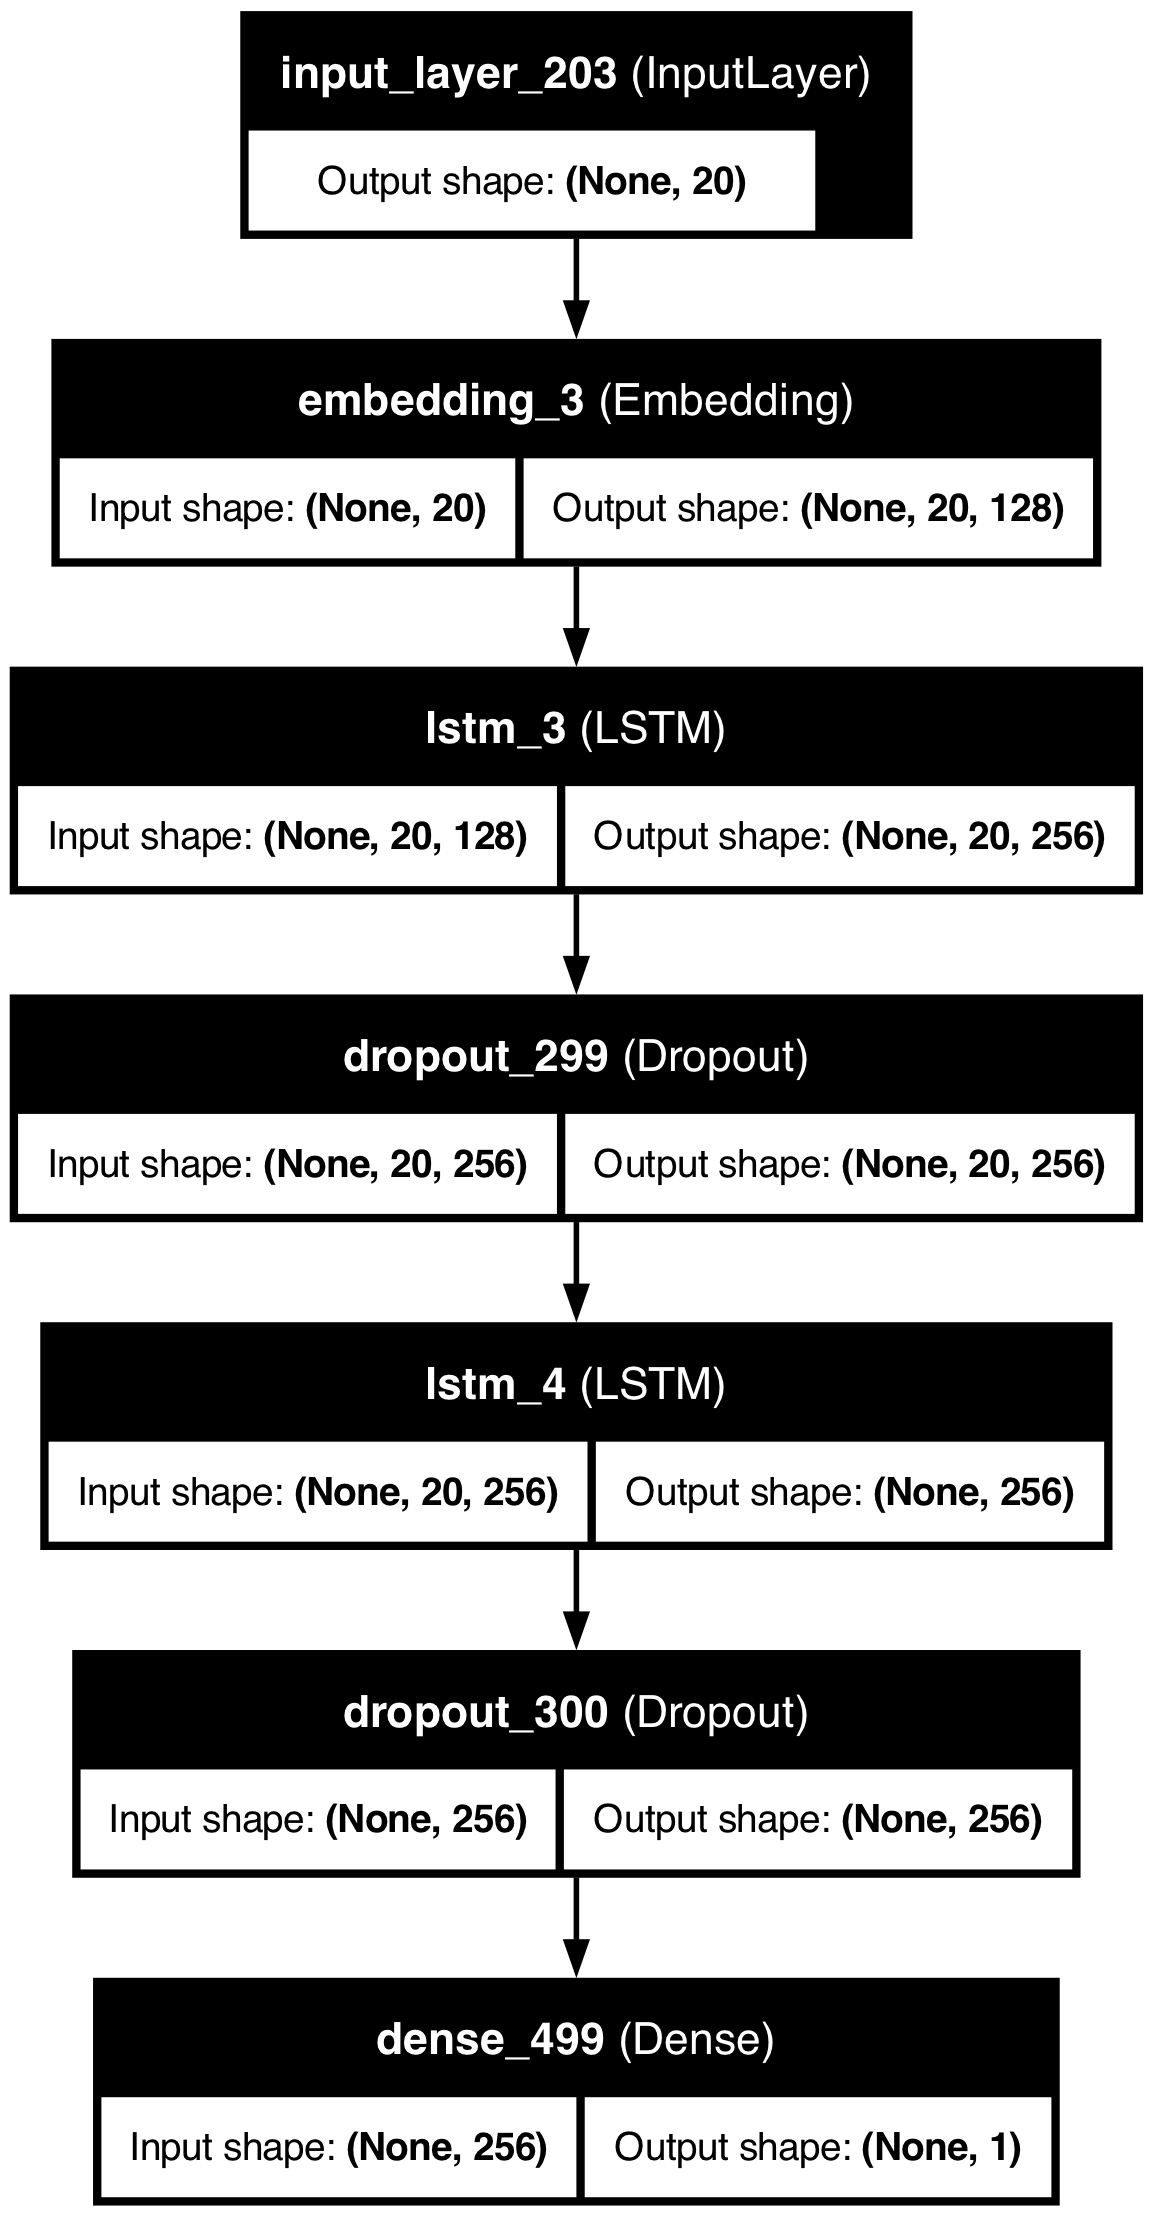

In [81]:
# Generate the plot
plot_model(model_3cIT, show_shapes=True, show_layer_names=True)

Epoch 1/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5638 - loss: 3.2047
Epoch 1: val_loss improved from inf to 1.63920, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.5645 - loss: 3.1998 - val_accuracy: 0.7683 - val_loss: 1.6392 - learning_rate: 1.0000e-04
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7997 - loss: 1.3706
Epoch 2: val_loss improved from 1.63920 to 0.91525, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7997 - loss: 1.3698 - val_accuracy: 0.7769 - val_loss: 0.9152 - learning_rate: 1.0000e-04
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8243 - loss: 0.7516
Epoch 3: val_loss improved from 0.91525 to 0.68570, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8243 - loss: 0.7513 - val_accuracy: 0.7704 - val_loss: 0.6857 - learning_rate: 1.0000e-04
Epoch 4/15
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms

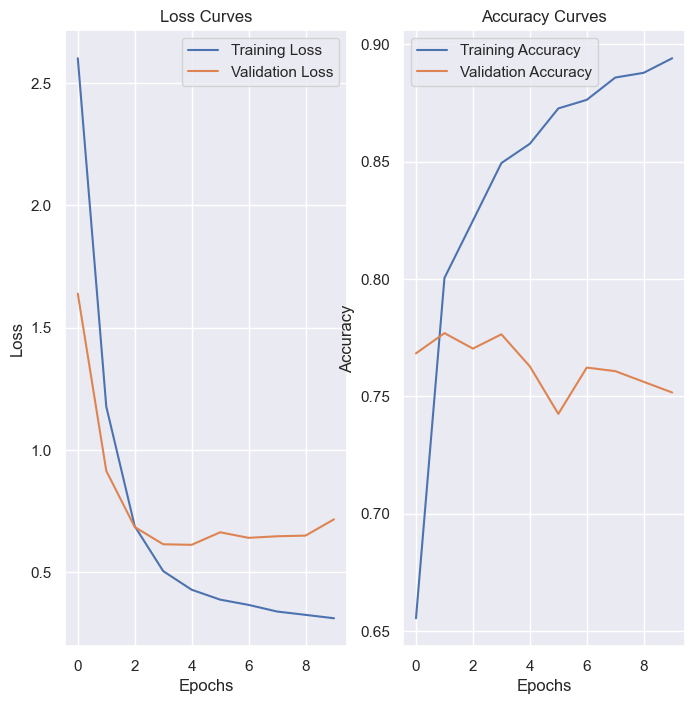

In [82]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3cIT_history = model_3cIT.fit(
    cX_train_lstm, cy_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3cIT_history)

In [83]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3cIT_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m3cIT_accuracy = accuracy_score(cy_test, cy_pred)
m3cIT_precision = precision_score(cy_test, cy_pred, average='weighted')
m3cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m3cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3cIT_accuracy:.2%}", f"{m3cIT_precision:.3f}", f"{m3cIT_recall:.3f}", f"{m3cIT_f1:.3f}", f"{m3cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
Model Performance          Results
         accuracy           77.99%
        precision            0.785
           recall            0.780
         f1_score            0.779
    time/instance 0.001692 seconds


In [84]:
store_results('Model_3c', m3cIT_accuracy, m3cIT_precision, m3cIT_recall, m3cIT_f1, m3cIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7    Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8    Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds


#### LSTM (stacked) with raw data

In [ ]:
def create_model(input_length=max_lengthR, input_dim=vocab_sizeR, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthR,
    input_dim=vocab_sizeR,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [86]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.769323 using {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}
0.760623 (0.009434) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 128}
0.735636 (0.021418) with: {'learning_rate': 0.001, 'lstm_units': 256, 'output_dim': 256}
0.592868 (0.131442) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 128}
0.583991 (0.118781) with: {'learning_rate': 0.001, 'lstm_units': 512, 'output_dim': 256}
0.762444 (0.010933) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 128}
0.766793 (0.016248) with: {'learning_rate': 0.0001, 'lstm_units': 256, 'output_dim': 256}
0.765478 (0.011728) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 128}
0.769323 (0.010629) with: {'learning_rate': 0.0001, 'lstm_units': 512, 'output_dim': 256}


In [87]:
# Extract the best parameters
best_params = grid_result.best_params_

In [89]:
# Create the final model using the best parameters
model_3rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_3rIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_803"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_205 (InputLayer)    │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 35, 256)        │     1,623,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 35, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_303 (Dropout)           │ (None, 35, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_304 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,297,665 (20.21 MB)

 Trainable params: 5,297,665 (20.21 MB)

 Non-trainable params: 0 (0.00 B)

None


python(51790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


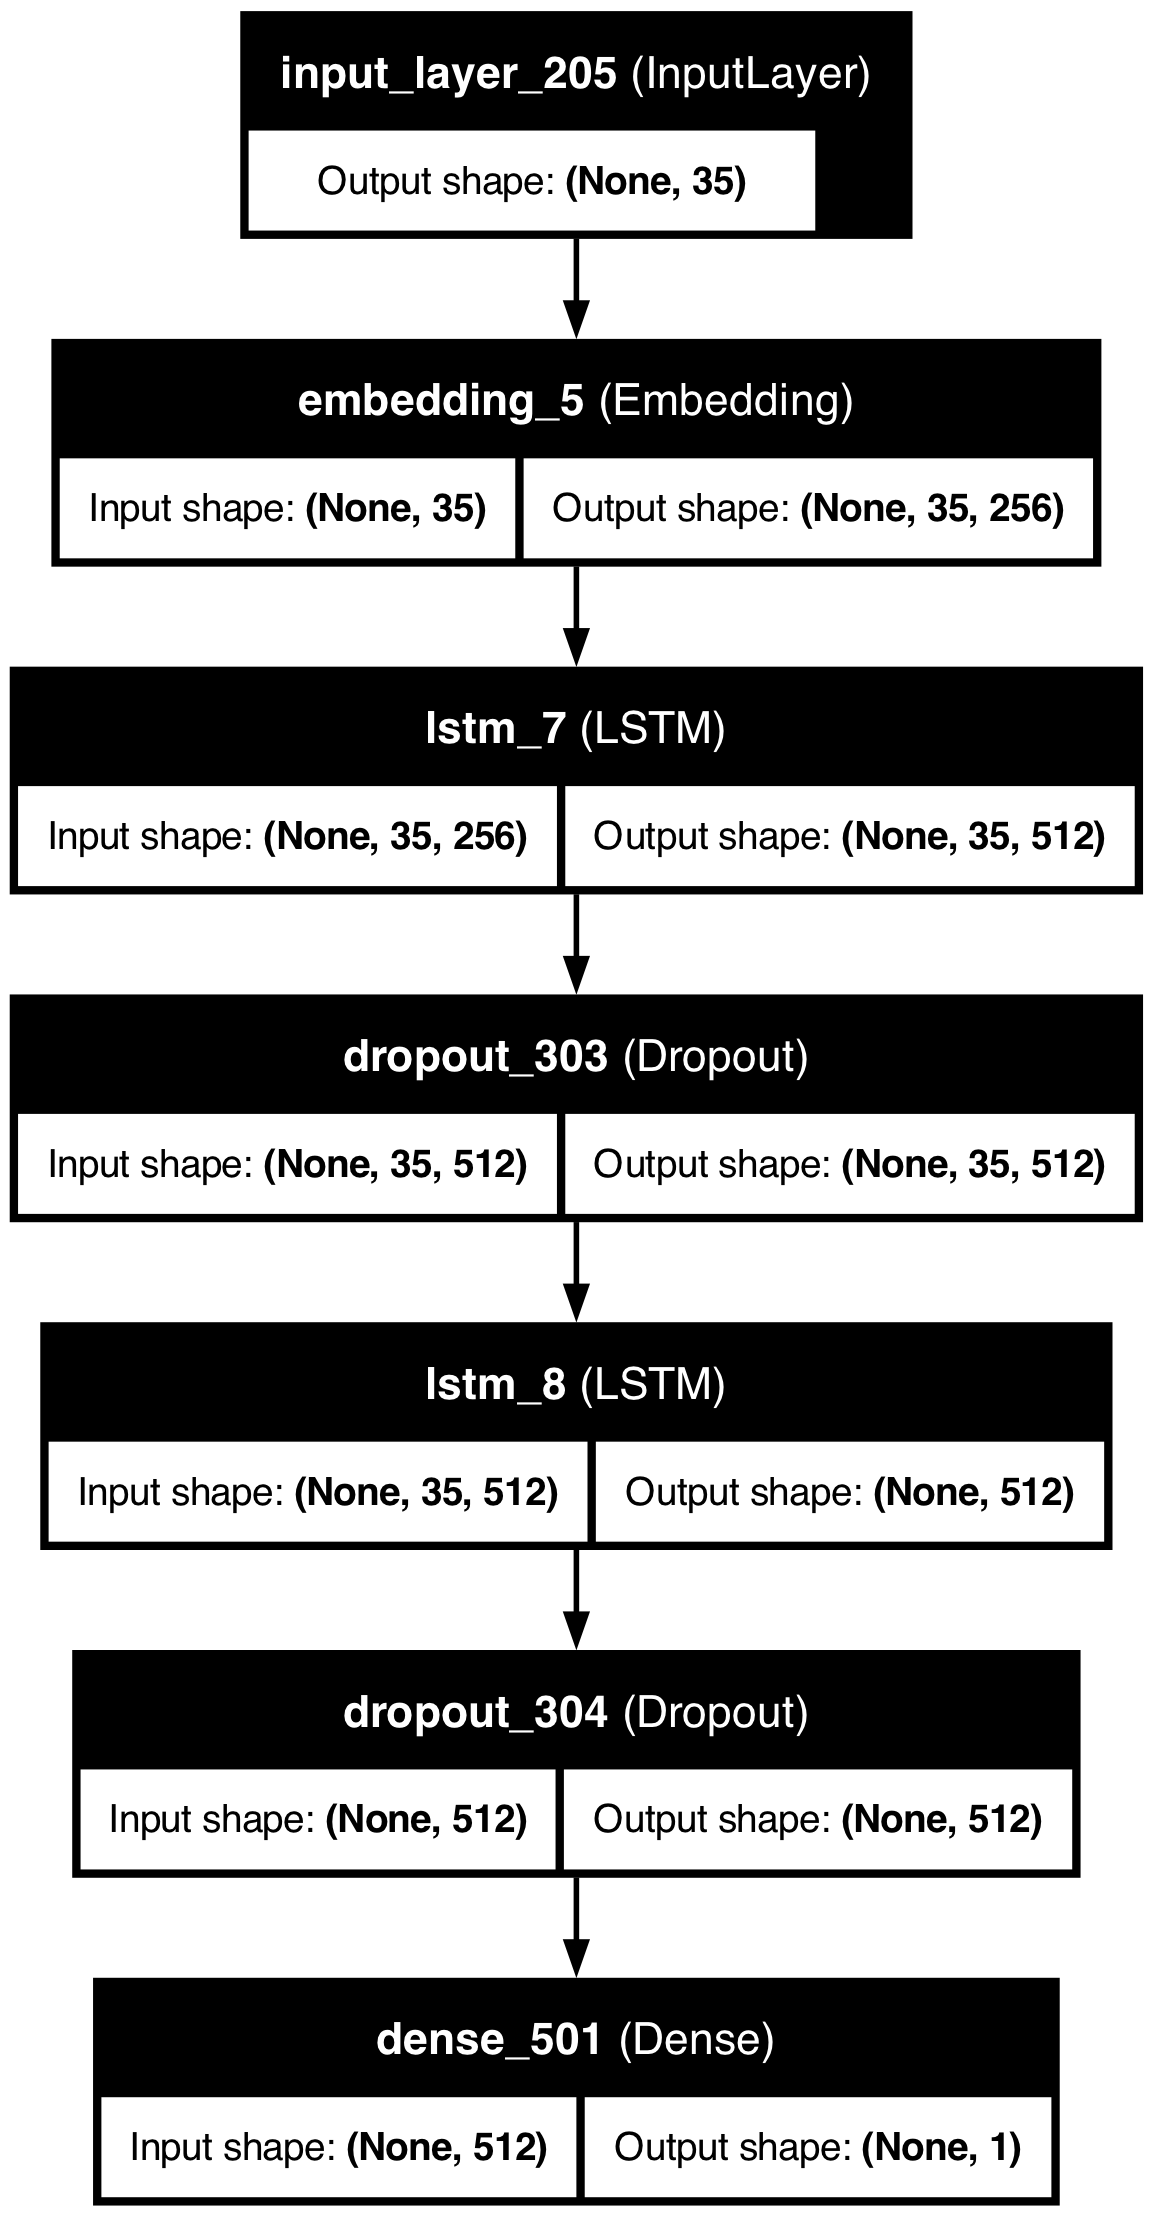

In [90]:
# Generate the plot
plot_model(model_3rIT, show_shapes=True, show_layer_names=True)

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5827 - loss: 5.3500
Epoch 1: val_loss improved from inf to 2.00088, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 136s 488ms/step - accuracy: 0.5830 - loss: 5.3445 - val_accuracy: 0.7699 - val_loss: 2.0009 - learning_rate: 1.0000e-04
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8152 - loss: 1.5658
Epoch 2: val_loss improved from 2.00088 to 1.07728, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 118s 477ms/step - accuracy: 0.8152 - loss: 1.5647 - val_accuracy: 0.6626 - val_loss: 1.0773 - learning_rate: 1.0000e-04
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8223 - loss: 0.7648
Epoch 3: val_loss improved from 1.07728 to 0.73358, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 118s 474ms/step - accuracy: 0.8223 - loss: 0.7645 - val_accuracy: 0.7769 - val_loss: 0.7336 - learning_rate: 1.0000e-04
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━

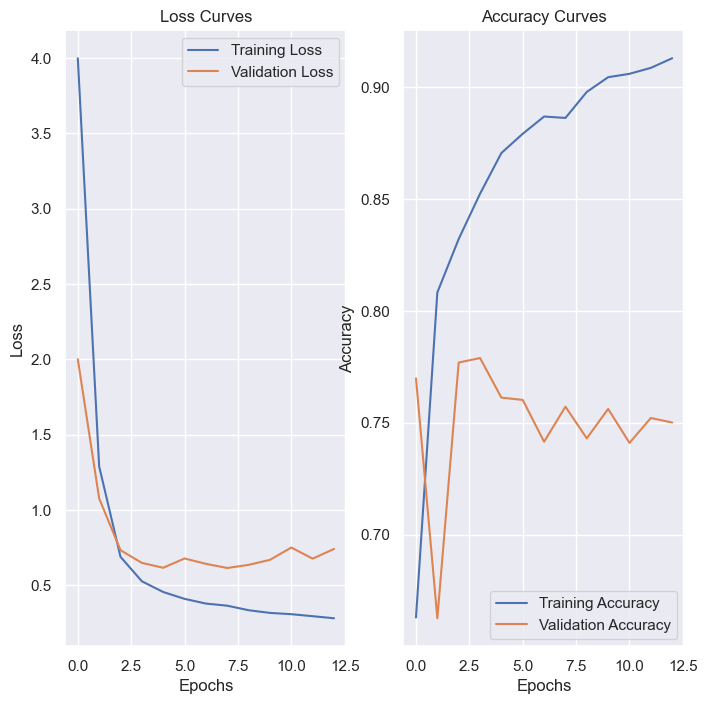

In [91]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3rIT_history = model_3rIT.fit(
    rX_train_lstm, ry_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3rIT_history)

In [92]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_3rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m3rIT_accuracy = accuracy_score(ry_test, ry_pred)
m3rIT_precision = precision_score(ry_test, ry_pred, average='weighted')
m3rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m3rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3rIT_accuracy:.2%}", f"{m3rIT_precision:.3f}", f"{m3rIT_recall:.3f}", f"{m3rIT_f1:.3f}", f"{m3rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step
Model Performance          Results
         accuracy           76.05%
        precision            0.763
           recall            0.761
         f1_score            0.760
    time/instance 0.004188 seconds


In [93]:
store_results('Model_3r', m3rIT_accuracy, m3rIT_precision, m3rIT_recall, m3rIT_f1, m3rIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3  Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4  Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5  Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6    Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7    Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8    Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9    Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds


### USE (Universal Sentence Encoder)

In [94]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

#### USE with clean data

In [95]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = np.array(USE_embedding(cX_train))
cX_test_embeddings = np.array(USE_embedding(cX_test))

2024-05-21 12:36:37.500994: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [97]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(cX_train_embeddings, cy_train, callbacks=[early_stopping])

In [99]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.778530 using {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.772156 (0.008203) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.778530 (0.003825) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.771448 (0.009239) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.774888 (0.004028) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.775394 (0.006847) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.777215 (0.007264) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.767704 (0.009888) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.772157 (0.006640) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.776305 (0.005266) with: {'learning_rat

In [100]:
# Extract the best parameters
best_params = grid_result.best_params_

In [101]:
# Create the final model using the best parameters
model_4cUST = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4cUST.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_624 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_378 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,793 (257.00 KB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(53071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


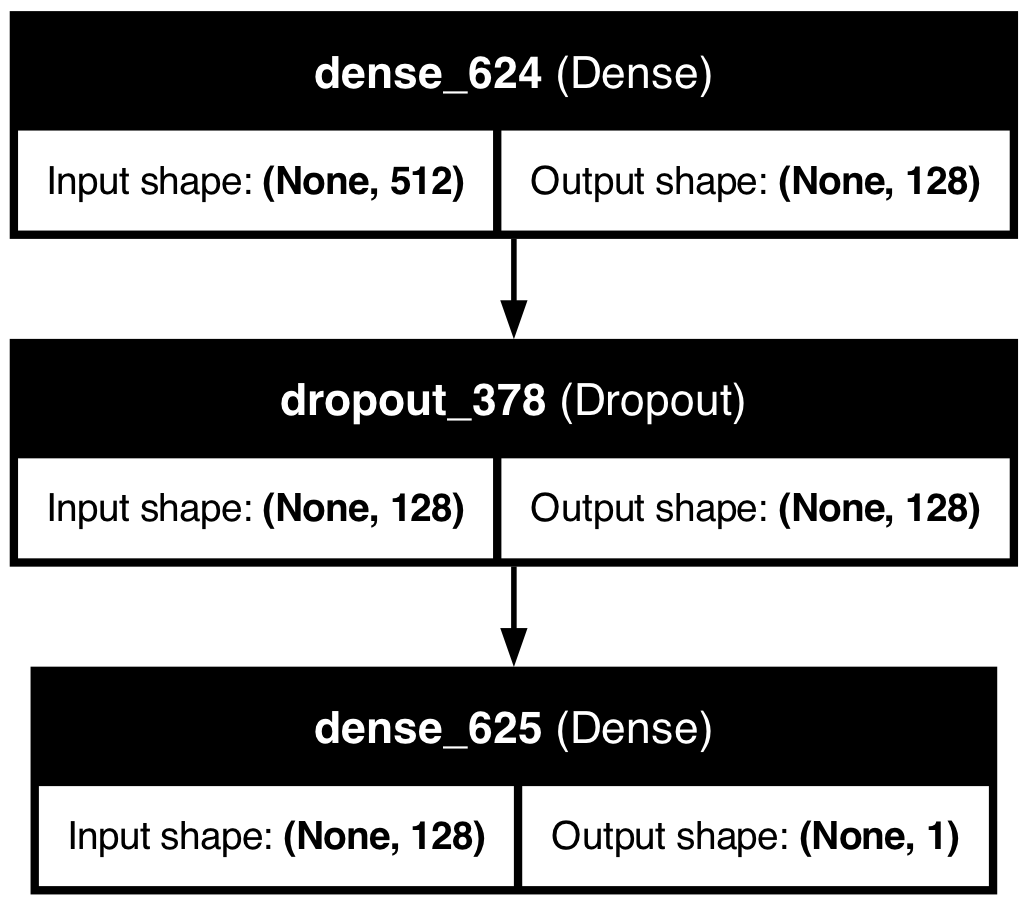

In [102]:
# Generate the plot
plot_model(model_4cUST, show_shapes=True, show_layer_names=True)

Epoch 1/300
221/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7106 - loss: 0.7263
Epoch 1: val_loss improved from inf to 0.53578, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7147 - loss: 0.7150 - val_accuracy: 0.7653 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 2/300
232/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.5259
Epoch 2: val_loss improved from 0.53578 to 0.52113, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7718 - loss: 0.5253 - val_accuracy: 0.7527 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 3/300
228/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7803 - loss: 0.4970
Epoch 3: val_loss improved from 0.52113 to 0.51228, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7801 - loss: 0.4974 - val_accuracy: 0.7623 - val_loss: 0.5123 - learning_rate: 0.0010
Epoch 4/300
220/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

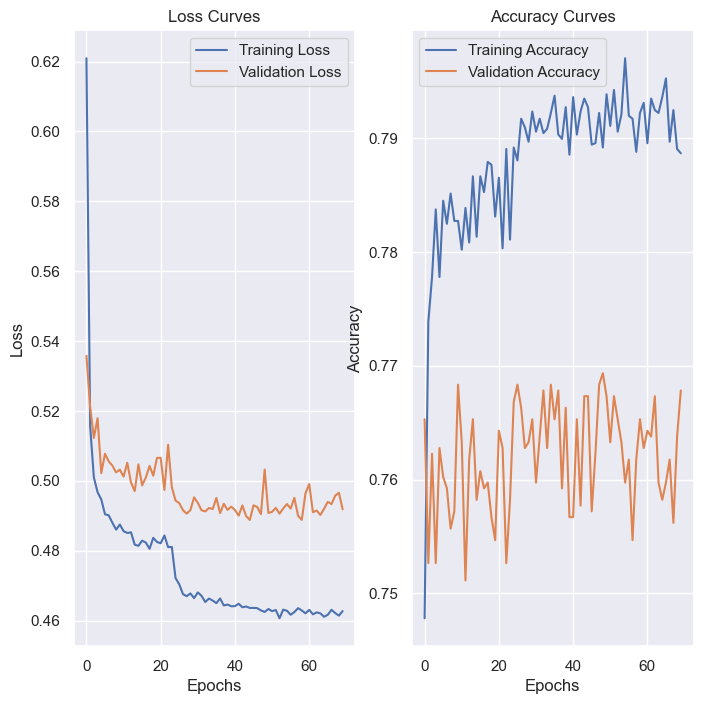

In [103]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4cUST_history = model_4cUST.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4cUST_history)

In [104]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4cUST.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4cUST_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4cUST_accuracy = accuracy_score(cy_test, cy_pred)
m4cUST_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4cUST_recall = recall_score(cy_test, cy_pred, average='weighted')
m4cUST_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4cUST_accuracy:.2%}", f"{m4cUST_precision:.3f}", f"{m4cUST_recall:.3f}", f"{m4cUST_f1:.3f}", f"{m4cUST_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           76.94%
        precision            0.771
           recall            0.769
         f1_score            0.769
    time/instance 0.000271 seconds


In [105]:
store_results('Model_1cUSE', m4cUST_accuracy, m4cUST_precision, m4cUST_recall, m4cUST_f1, m4cUST_time_per_instance)

# View the consolidated results
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3    Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4    Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5    Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6      Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7      Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8      Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9      Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds
10  Model_1cUSE   76.94%     0.771  0.769    0.769  0.000271 seconds


#### USE with raw data

In [106]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = np.array(USE_embedding(rX_train))
rX_test_embeddings = np.array(USE_embedding(rX_test))

In [107]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(rX_train_embeddings, ry_train, callbacks=[early_stopping])

In [109]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793403 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.790671 (0.006209) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.789255 (0.003143) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.788446 (0.009665) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.790064 (0.004702) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.789154 (0.007264) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.786624 (0.006765) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.784096 (0.002061) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.793403 (0.003807) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.792998 (0.005478) with: {'learning_rat

In [110]:
# Extract the best parameters
best_params = grid_result.best_params_

In [111]:
# Create the final model using the best parameters
model_4rUSF = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4rUSF.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_749 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_453 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_454 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(53678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


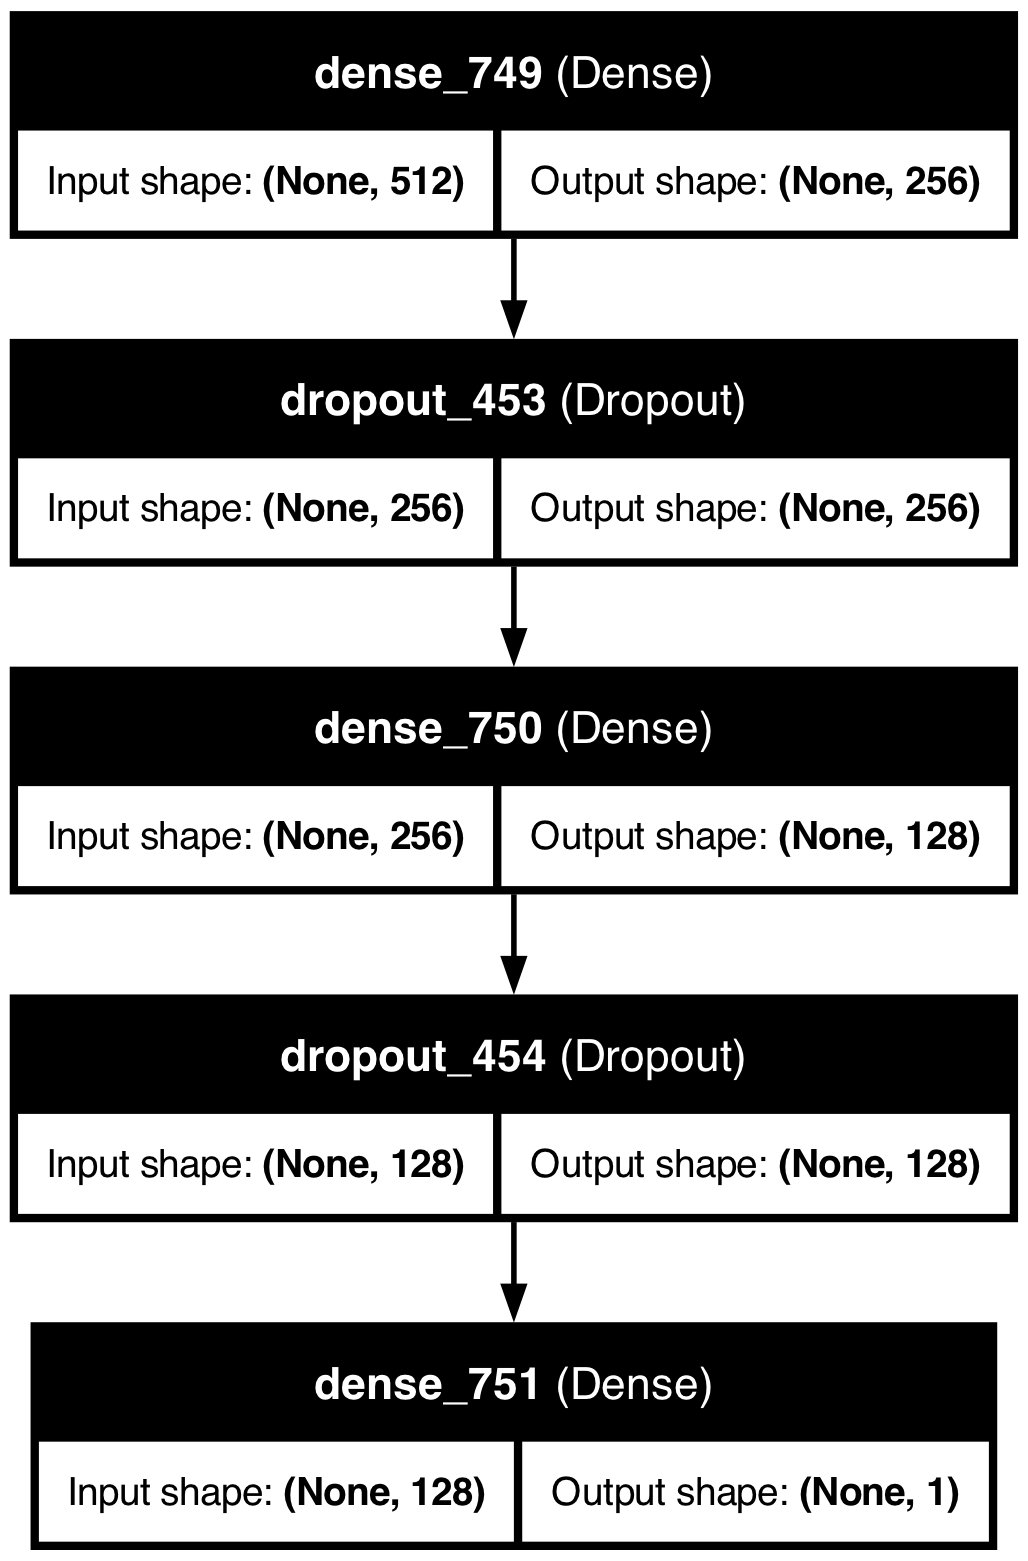

In [112]:
# Generate the plot
plot_model(model_4rUSF, show_shapes=True, show_layer_names=True)

Epoch 1/300
239/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 0.8381
Epoch 1: val_loss improved from inf to 0.55225, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7214 - loss: 0.8313 - val_accuracy: 0.7516 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 2/300
241/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7782 - loss: 0.5256
Epoch 2: val_loss improved from 0.55225 to 0.52454, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7782 - loss: 0.5255 - val_accuracy: 0.7734 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 3/300
239/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - loss: 0.5047
Epoch 3: val_loss improved from 0.52454 to 0.52046, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7845 - loss: 0.5048 - val_accuracy: 0.7577 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 

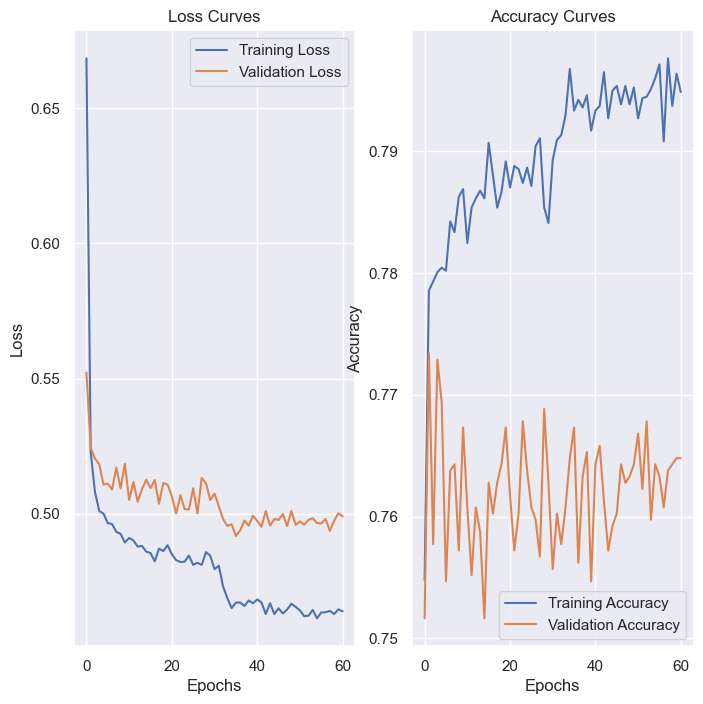

In [113]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4rUSF_history = model_4rUSF.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4rUSF_history)

In [114]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4rUSF.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4rUSF_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4rUSF_accuracy = accuracy_score(ry_test, ry_pred)
m4rUSF_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4rUSF_recall = recall_score(ry_test, ry_pred, average='weighted')
m4rUSF_f1 = f1_score(ry_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4rUSF_accuracy:.2%}", f"{m4rUSF_precision:.3f}", f"{m4rUSF_recall:.3f}", f"{m4rUSF_f1:.3f}", f"{m4rUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model Performance          Results
         accuracy           76.25%
        precision            0.767
           recall            0.763
         f1_score            0.769
    time/instance 0.000630 seconds


In [115]:
store_results('Model_1rUSE', m4rUSF_accuracy, m4rUSF_precision, m4rUSF_recall, m4rUSF_f1, m4rUSF_time_per_instance)

# View the consolidated results
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3    Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4    Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5    Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6      Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7      Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8      Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9      Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds
10  Model_1cUSE   76.94%     0.771  0.769    0.769  0.000271 seconds
11  Model_1rUSE   76.25%     0.767  0.763    0.769  0.000630 seconds


## Summary of all models

In [135]:
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.20%     0.785  0.782    0.781  0.000397 seconds
3    Model_1rTI   79.49%     0.797  0.795    0.795  0.000296 seconds
4    Model_1cWV   74.07%     0.743  0.741    0.740  0.000223 seconds
5    Model_1rWV   72.37%     0.726  0.724    0.723  0.000192 seconds
6      Model_2c   75.93%     0.760  0.759    0.759  0.000928 seconds
7      Model_2r   76.74%     0.770  0.767    0.767  0.001405 seconds
8      Model_3c   77.99%     0.785  0.780    0.779  0.001692 seconds
9      Model_3r   76.05%     0.763  0.761    0.760  0.004188 seconds
10  Model_1cUSE   76.94%     0.771  0.769    0.769  0.000271 seconds
11  Model_1rUSE   76.25%     0.767  0.763    0.769  0.000630 seconds


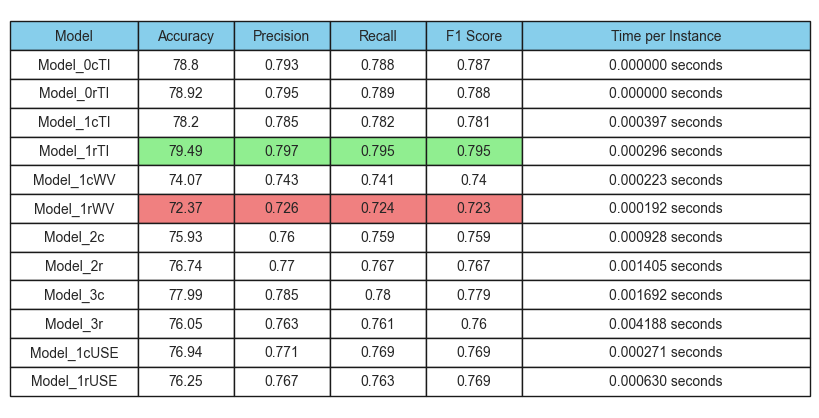

In [136]:
# Convert relevant columns to float for comparison
results_df['Precision'] = results_df['Precision'].astype('float')
results_df['Recall'] = results_df['Recall'].astype('float')
results_df['F1 Score'] = results_df['F1 Score'].astype('float')
results_df['Accuracy'] = results_df['Accuracy'].str.rstrip('%').astype('float')

# Find the best and worst values
best_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].max()
worst_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].min()

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 0.6 + 0.3 * len(results_df)))  # Smaller height factor to reduce vertical space
ax.axis('off')  # Hide the axes

# Convert DataFrame to a list of lists for cellText
data = results_df.values.tolist()

# Table
table = ax.table(
    cellText=data,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=["skyblue"]*len(results_df.columns),  # Color for the column headers
    colWidths=[0.16, 0.12, 0.12, 0.12, 0.12, 0.36]  # Adjust column widths to fit your content
)

# Highlight best and worst values
for row in range(1, len(data) + 1):  # Skip the header row
    for col, col_name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
        if results_df.at[row-1, col_name] == best_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightgreen')
        elif results_df.at[row-1, col_name] == worst_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightcoral')

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust font size if necessary
table.scale(1, 1.4)  # Scale table size, reduce x-scaling to minimize horizontal space

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.05)  # Minimize margins as much as possible

plt.show()

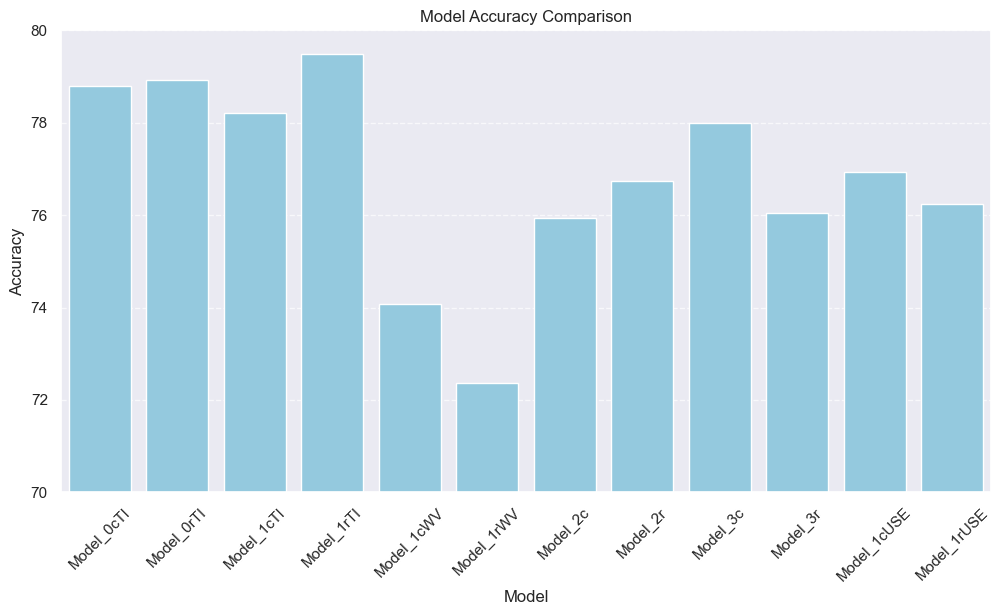

In [138]:
# Creating a bar plot for model accuracy comparison with seaborn in sky blue, without error bars
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, color='skyblue', ci=None)

# Adjusting the aesthetics
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(70, 80)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()